# Tools for Modeling: The Brain Modeling Toolkit and SONATA data format

## https://github.com/AllenInstitute/bmtk/tree/develop/docs/tutorial/modeling_tut_2021

This tutorial will show how to build and simulate a toy model of the mouse V1 cortical area network using the Brain Modeling Toolkit (BMTK) [\[Dai et al., PLOS Comp. Bio., 2020\]](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008386). Including how to modify and simulate larger more realistic visual cortical models released by the Allen Institute [\[Billeh et al., Neuron, 2020\]](https://www.cell.com/neuron/pdf/S0896-6273(20)30067-2.pdf). The tutorial will also briefly explain the SONATA data format [\[Dai et al., PLOS Comp. Bio., 2020\]](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007696) and how the BMTK uses the format to describe network models, simulations and results.

In this tutorial we will show how to build and simulate a a modistly sized toy network based on the Mouse Primary Visual Cortex (V1) for Layer 4 (which is the primary layer of the L4 for receiving thamalic stimulus). The L4 model [\[Arkhipov et al., PLOS Comp. Bio., 2018\]](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006535), further described [here](https://portal.brain-map.org/explore/models/l4-mv1), will have a full model that contains 45,000+ cells and millions of connections: 

<img src="images/layer4_side_view.png" alt="Drawing" style="width: 300px; float: left"/>
<img src="images/layer4_angled_view.png" alt="Drawing" style="width: 300px; float: left"/>

Building and running the actual L4 model can take many hours and will require access to HPC resources. The toy model we will build and simulate will have only 300 cells to allow us to build and simulate the model in a few minutes for most desktop and laptop machines.

For more information about cortical modeling and simulation at the Allen Institute:
https://portal.brain-map.org/explore/models

For more information and tutorials on using the BMTK:
https://alleninstitute.github.io/bmtk

## Installing BMTK
[\[https://alleninstitute.github.io/bmtk/installation.html\]](https://alleninstitute.github.io/bmtk/installation.html)

BMTK will require python 2.7 or 3.6+. You can clone the latest developement branch from https://github.com/AllenInstitute/bmtk.git. 

```bash
 $ https://github.com/AllenInstitute/bmtk
 $ cd bmtk
 $ python setup.py install
```


Alternatively one can install using python's pip utility:

```bash
 $ pip install bmtk
```

Or if you're using a CONDA environment:

```bash
 $ conda install -c kaeldai bmtk
```

For simulation [NEURON](https://www.neuron.yale.edu/neuron/) will also be required to be installed (including python bindings). To quickly install NEURON on your machine:
```bash
 $ pip install neuron
```

or 
```
 $ conda install -c conda-forge neuron
```


#### The BMTK Docker Image

We have included a docker image that will come with BMTK, neuron, and a ready-to-use jupyter notebook server with this tutorial and it's content already installed. To run the docker image

```bash
 ## Linux or OSX
 $ docker run -v $(pwd):/home/shared/workspace -p 8888:8888 alleninstitute/bmtk jupyter
 
 ## Windows PowerShell
 $ docker run -v ${PWD}:/home/shared/workspace -p 8888:8888 alleninstitute/bmtk jupyter
```

Then open a web browser to __127.0.0.1:8888/__. This current tutorial can be found under the folder *tutorials/modeling_tut_2021/Mouse_L4.ipynb*.

## Building the Network

<img src="images/bmtk_workflow_builder.png" style="width: 700px; float: left"/>

Before we can start simulation we must first build (or receive from a third party) the network model files. To create our toy network of 300 cells in BMTK we will use the *builder* component, which allows us to build heterogeneous, multi-graph networks and save them in the SONATA format.


#### Building the cells
<img src="images/builder_add_nodes.png" style="width: 350px; float: left"/>

The first step is figuring out different cell types and parameters we want to use in our network. When we know that we can begin building our network model first by initializing the network using _bmtk.builder.networks.NetworkBuilder_ plus calls to _add_nodes()_ method

In [1]:
import numpy as np

from bmtk.builder.networks import NetworkBuilder

# intialize a new population of cells called "V1"
v1 = NetworkBuilder('V1')

# Add a population of 80 "Scnn1a" type nodes
v1.add_nodes(
    N=80,
    
    # Reserved SONATA keywords used during simulation
    model_type='biophysical',
    model_template='ctdb:Biophys1.hoc',
    dynamics_params='472363762_fit.json',
    morphology='Scnn1a_473845048_m.swc',
    model_processing='aibs_perisomatic',
    
    # The x, y, z locations of each cell in a column
    x=np.random.normal(0.0, 20.0, size=80),
    y=np.random.uniform(400.0, 500.0, size=80),
    z=np.random.normal(0.0, 20.0, size=80),
    
    # Euler rotations of the cells
    rotation_angle_xaxis=np.random.uniform(0.0, 2*np.pi, size=80),
    rotation_angle_yaxis=np.random.uniform(0.0, 2*np.pi, size=80),
    rotation_angle_zaxis=-3.646878266,
    
    # Optional parameters
    tuning_angle=np.linspace(start=0.0, stop=360.0, num=80, endpoint=False),
    pop_name='Scnn1a',
    location='L4',
    ei='e',
)

The above call to add_nodes() will add __N=80__ different individual cells to our network. 

The attributes __model_type__, __model_template__, __dynamics_params__, __model_processing__ and __morphology__ are SONATA reserved keywords that will instruct BMTK (or other SONATA compliant tools) how to build cell models during the simulation. In this model we are using biophysically realistic models, with dynamical parameters (.json) and morphology (.swc) that we can download from the [Allen Cell Types Database](https://celltypes.brain-map.org/data). We have already downloaded the required json and swc files and have saved them under *components/biophysical_neuron_templates* and 
*components/morphologies/*, respectively.

Attributes __x__, __y__, __z__ are used as the euclidian locations of the cells, while the __rotation_angle__ parameters are used to orientat to rotations of cells. Note that for the x and y rotations we are passing in an array of size N, but the z rotation is defined by a scalar. SONATA and the BMTK Network Builder allows us to differentiate between attributes that are unique to each cell versus shared attributes. Each of the 80 cells will have unique x and y rotations, but share the same pre-calculated z rotatation

The final remaining attributes are not reserved SONATA keywords, but rather optional attributes that will be helpful during analysis. The __tuning_angle__ property (how well a cell is tuned for different stimulus grating) is an attribute shown is excitatory cells of the visual cortex and thus wouldn't be applicable to other models or even non-exciatory cells-types

We now can ad other cell-types to our model, including inhibitory PV (parvalbumin) cells, with future calls to __add_nodes__:

In [2]:
v1.add_nodes(
    # Rorb excitatory cells
    N=80, pop_name='Rorb', location='L4', ei='e',
    model_type='biophysical',
    model_template='ctdb:Biophys1.hoc',
    dynamics_params='473863510_fit.json',
    morphology='Rorb_325404214_m.swc',
    model_processing='aibs_perisomatic',
    x=np.random.normal(0.0, 20.0, size=80),
    y=np.random.uniform(400.0, 500.0, size=80),
    z=np.random.normal(0.0, 20.0, size=80),   
    rotation_angle_xaxis=np.random.uniform(0.0, 2*np.pi, size=80),
    rotation_angle_yaxis=np.random.uniform(0.0, 2*np.pi, size=80),
    rotation_angle_zaxis=-4.159763785,
    tuning_angle=np.linspace(start=0.0, stop=360.0, num=80, endpoint=False),
)


v1.add_nodes(
    # Nr5a1 excitatory cells
    N=80, pop_name='Nr5a1', location='L4', ei='e',
    model_type='biophysical',
    model_template='ctdb:Biophys1.hoc',
    dynamics_params='473863035_fit.json',
    morphology='Nr5a1_471087815_m.swc',
    model_processing='aibs_perisomatic',
    x=np.random.normal(0.0, 20.0, size=80),
    y=np.random.uniform(400.0, 500.0, size=80),
    z=np.random.normal(0.0, 20.0, size=80),   
    rotation_angle_xaxis=np.random.uniform(0.0, 2*np.pi, size=80),
    rotation_angle_yaxis=np.random.uniform(0.0, 2*np.pi, size=80),
    rotation_angle_zaxis=-4.159763785,
    tuning_angle=np.linspace(start=0.0, stop=360.0, num=80, endpoint=False),
)

v1.add_nodes(
    # Parvalbuim inhibitory cells, note these don't have a tuning angle and ei=i
    N=60, pop_name='PV1', location='L4', ei='i',
    model_type='biophysical',
    model_template='ctdb:Biophys1.hoc',
    dynamics_params='472912177_fit.json',
    morphology='Pvalb_470522102_m.swc',
    model_processing='aibs_perisomatic',
    x=np.random.normal(0.0, 20.0, size=60),
    y=np.random.uniform(400.0, 500.0, size=60),
    z=np.random.normal(0.0, 20.0, size=60),   
    rotation_angle_xaxis=np.random.uniform(0.0, 2*np.pi, size=60),
    rotation_angle_yaxis=np.random.uniform(0.0, 2*np.pi, size=60),
    rotation_angle_zaxis=-2.539551891
)


#### Creating the connections 
<img src="images/builder_add_edges.png" style="width: 350px; float: left"/>


Now that we have our cells/nodes, we can go ahead and create the synapse/connectivity matrix using the __add_edges__ method. We will want to call this method multiple times to add different connection types with different properties and rules. For each connection type we must select what subpopulation of cells to use for the source (pre-synaptic) and target (post-synaptic) cells. We can select our cells using any combination of attributes

In [3]:
v1.add_edges(
    ## Exc --> Inh type connections.
    source={'ei': 'e'}, 
    target={'ei': 'i'},
    
    # Each source (ei='e') cell will connect once to every target (e) cell
    connection_rule=1,
              
    # SONATA keywords
    syn_weight=0.0006,
    delay=2.0,
    dynamics_params='ExcToInh.json',
    model_template='exp2syn',
    
    # Special BMTK attributes specifying where to set target synape location
    target_sections=['somatic', 'basal'],
    distance_range=[0.0, 1.0e+20]
)

v1.add_edges(
    ## Inh --> Exc type connections.
    source={'ei': 'i'}, 
    target={'ei': 'e'},
    
    connection_rule=1,
    
    syn_weight=0.0002,
    delay=2.0,
    dynamics_params='InhToExc.json',
    model_template='exp2syn',   
    target_sections=['somatic', 'basal', 'apical'],
    distance_range=[0.0, 50.0]
)

The __connection_rule__ parameter is used to determine the number of connections/synapses between each source and target cell. In the simplist case like above we can pass in a scalar value. You may also pass in a matrix of shape T x S (T=# or targets, S=# of sources), or use in a custom function.

With a user defined function it will pass in a source and target, which can be used as dictionaries to access cell parameters, and expects to return the number of connections
```python
def <my_connection_rule>(source, target, **opt_params):
    return N
```

For example for Inh --> Inh connection we want there to be no connections if the cells have the same id, otherwise randomly select the number of synapses

In [4]:
def ignore_autapses(source, target):
    # No synapses if source == target, otherwise randomize
    if source['node_id'] == target['node_id']:
        return 0
    else:
        return np.random.randint(1, 5)

v1.add_edges(
    ## Inh --> Inh type connections.
    source={'ei': 'i'}, 
    target={'ei': 'i'},
    
    connection_rule=ignore_autapses,
              
    syn_weight=0.00015,
    delay=2.0,
    dynamics_params='InhToInh.json',
    model_template='exp2syn',
    target_sections=['somatic', 'basal'],
    distance_range=[0.0, 1.0e+20]
)


For Exc --> Exc we want to test an theory that cells with closer __tuning_angle__ are more likely to be connected with each other:

In [5]:
def tuning_angle(source, target, max_syns):
    # ignore autoapses
    if source['node_id'] == target['node_id']:
        return 0
    
    # num of synapses is higher the closer the tuning_angles
    src_tuning = source['tuning_angle']
    trg_tuning = target['tuning_angle']
    dist = np.abs((src_tuning - trg_tuning + 180) % 360 - 180)
    p_dist = 1.0 - (np.max((dist, 10.0)) / 180.0)
    return np.random.binomial(n=max_syns, p=p_dist)

v1.add_edges(
    source={'ei': 'e'}, 
    target={'ei': 'e'},
    
    connection_rule=tuning_angle,
    connection_params={'max_syns': 5}, # pass in options to tuning_angle function
    
    syn_weight=3.0e-05,
    delay=2.0,
    dynamics_params='ExcToExc.json',
    model_template='exp2syn',
    target_sections=['basal', 'apical'],
    distance_range=[30.0, 150.0],
    
    # Will allow us to use our own custom functions to set syn_weight during simulation
    weight_function='set_syn_weight'
)

Other connection parameters, particularly __syn_weight__ and __delay__, are scalar values and will be the same for each connection. There are multiple ways to set such values so it is customized for each connection. We will show one way of doing so later during the simulation stage, using the special BMTK __weight_function__ keyword.

#### Building the network
<img src="images/builder_complete_network.png" style="width: 300px; float: left"/>

Finally we want to build our network and save the network files in SONATA format into the _network/_ directory. BMTK will intuit the names of the files.

In [6]:
v1.build()
v1.save(output_dir='network')

#### External Network

BMTK and SONATA gives modelers the options to build different parts of a network piecewise. For example we may want to build models of thalamacortical and higher cortical areas that we can connect to our V1 model.

Next we create a separate network of the LGN, an flat area of the Thalamus with exciatory cells that project onto the V1. As before we define our cells, connect them to the v1 network, then build and save them as SONATA files in the _network/_ directory.

In [7]:
lgn = NetworkBuilder('LGN')  # Initialize network called 'lgn'

lgn.add_nodes(
    N=50, 
    model_type='virtual',
    model_template='lgnmodel:sOFF_TF8',
    dynamics_params='sOFF_TF8.json',
    
    # Special keyword used to determine the location and size of unit in 
    # the receptive field
    x=np.random.uniform(0.0, 240.0, 50),
    y=np.random.uniform(0.0, 120.0, 50),
    spatial_size=1.0
)

lgn.add_nodes(
    N=50, 
    model_type='virtual',
    model_template='lgnmodel:sON_TF8',
    dynamics_params='sON_TF8.json',
    x=np.random.uniform(0.0, 240.0, 50),
    y=np.random.uniform(0.0, 120.0, 50),
    spatial_size=1.0
)

lgn.add_edges(
    source=lgn.nodes(), # Select all LGN cells as the sources
    target=v1.nodes(ei='e'), # select V1 exc cells are the target
              
    connection_rule=lambda *_: np.random.randint(0, 5),
    syn_weight=0.0003,
    delay=2.0,
    dynamics_params='LGN_ExcToExc.json',
    model_template='exp2syn',
    target_sections=['basal', 'apical', 'somatic'],
    distance_range=[0.0, 50.0]
)

lgn.add_edges(
    source=lgn.nodes(), # Select all LGN cells as the sources
    target=v1.nodes(ei='i'), # select V1 exc cells are the target
              
    connection_rule=lambda *_: np.random.randint(0, 5),
    syn_weight=0.002,
    delay=2.0,    
    dynamics_params='LGN_ExcToInh.json',
    model_template='exp2syn',
    target_sections=['basal', 'apical'],
    distance_range=[0.0, 1e+20]
)

lgn.build()
lgn.save(output_dir='network')


Unlike the V1 cells, the LGN cells are __model_type=virtual__. In SONATA _virtual_ cells are special type of cell models that can't be recorded from, but can be used to synapse onto and stimulate other cells. There are essentially place-holders for spike trains (that will be set during the simulation).

we have given the lgn special dynamics_params and model_template values, however these won't be used during the V1 simulation. There parameter values are used by FilterNet module.

# Simulating the Network


<img src="images/bmtk_workflow_simulator.png" style="width: 700px; float: left"/>

Finally we want to build our network and save the network files in SONATA format into the _network/_ directory. BMTK will intuit the names of the files.

Now that we have built the SONATA network models files (or recieved the files from another source), we can go ahead and setup a simulation to run. To simulate the multi-compartment cell models we will use the BioNet component of the BMTK - which uses the [NEURON](https://www.neuron.yale.edu/neuron/) simulator libraries for simulating our network. 

Before we can do that there are still a few things that need to be taken care of, including setting up run-time parameters, choosing the stimulus, and deciding what to record.

### Simulation Directory Structure

Almost all of the parameters required to initialize and run a full V1 simulation will be stored in a [SONATA base json configuration file](https://github.com/AllenInstitute/sonata/blob/master/docs/SONATA_DEVELOPER_GUIDE.md#tying-it-all-together---the-networkcircuit-config-file), in this case named _config.bionet.json_. If you need to (re)create the file the following command will create a template:

```python
  python -m bmtk.utils.sim_setup  \
   --network network              \
   --dt 0.1                       \
   --tstop 2000.0                 \  
   --compile-mechanisms           \
   --include-examples             \
   --config=config.bionet.json    \
   bionet .
```

Opening up the json with a text editor we can see the configuration is divided into different sections


#### "networks"

This section contains paths to the sonata network files we built above. We can use this to add or remove node populations and edges before running another simulation.


#### "components"

Contains the paths to the different external files and parameters required to run a simulation; morphologies, electricophysicological parameters (eg. NeuroML files), synaptic model parameters, etc. Files that are not directly defined as a part of the SONATA files but used by specific simulator software (eg NEURON, NEST).

The required files for this tutorial has already be created. In other cases one would likely have to spend a signficant amount of time creating the optimized parameter files.


#### "run"

Run-time parameters and conditions, including simulation time and the time-step (all time values are in miliseconds).


#### "output"

Paths and parameters used for simulation output and logging.



#### "reports"

By default BMTK will record the V1 cell spikes into a file specified under **outputs/spikes_file**. For these types of models we can also record other parameters like membrane potential, calcium fluxuation, or extracellular electrical fields by adding to the "reports" section of the configuration file. 

For example the following can be used to record the soma membrane potential traces for our Scnn1a cells and save them in *output/membrane_potential.h5*

```json
    "membrane_potential": {
      "cells": {
          "population": "V1", 
          "pop_name": "Scnn1a"
      },
      "variable_name": "v",
      "module": "membrane_report",
      "sections": "soma"
    }
```

#### "inputs"

This section can be used to specify one or more stimulus we want to use on our V1 model. Depending on the type of cell models being used, we can use spike trains, current clamps, voltage clamps, or extracellular electrodes.  

For our V1 network we created a population of LGN "virtual" cells that synapse onto our V1 cells and drive them with spike trains. All that is missing is a "spike-trains" file, which can be either a CSV, NWB, or SONATA HDF5 file. BMTK includes way to create spike-train files.

The following will create a series of spike trains for the LGN cells using a Poisson distrubtion of 8 Hz:

In [8]:
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator

psg = PoissonSpikeGenerator(population='LGN')
psg.add(
    node_ids=range(0, 100),
    firing_rate=8.0,    # We can also pass in a nonhomoegenous function/array
    times=(0.0, 2.0)    # Firing starts at 0 s up to 2 seconds
)

psg.to_sonata('inputs/lgn_spikes.poisson.h5')
psg.to_csv('inputs/lgn_spikes.poisson.csv')

and update the "inputs" section 

```json
    "LGN_spikes": {
        "input_type": "spikes",
        "module": "h5",
        "input_file": "./inputs/lgn_spikes.poisson.h5",
        "node_set": "LGN"
    }
```

BMTK also includes a tool FilterNet that allows us to turn movies and images into firing rates using optimized filter models, which we will do in future sections.

### Running the simulation

Now that we have our configuration files as we need, we can go ahead and run a simulation. We can execute the *run_bionet.py* script using the command line option:

```bash
 $ python run_bionet.py config.bionet.json
```

Although this toy network is small enough to run most modern computers and laptops, for larger networks we may need to run the program on a cluster with <N> cores. To do so 

```bash
 $ mpirun -np <N> nrniv -mpi -python run_bionet.py config.bionet.json
```


In [9]:
from bmtk.simulator import bionet

conf = bionet.Config.from_json('config.bionet.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2021-06-24 11:23:10,647 [INFO] Created log file
2021-06-24 11:23:10,780 [INFO] Building cells.
2021-06-24 11:23:35,286 [INFO] Building recurrent connections
2021-06-24 11:25:53,734 [INFO] Building virtual cell stimulations for LGN_spikes
2021-06-24 11:26:18,614 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2021-06-24 11:26:18,615 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2021-06-24 11:26:18,616 [INFO] Block save every 5000 steps
2021-06-24 11:27:47,544 [INFO]     step:5000 t_sim:500.00 ms
2021-06-24 11:29:18,175 [INFO]     step:10000 t_sim:1000.00 ms
2021-06-24 11:30:49,458 [INFO]     step:15000 t_sim:1500.00 ms
2021-06-24 11:32:21,530 [INFO]     step:20000 t_sim:2000.00 ms
2021-06-24 11:32:21,593 [INFO] Simulation completed in 6.0 minutes, 2.979 seconds 


As specified in the "output" and "reports" section, the results of the simulation will be saved in different files in the _output_ directory. The spike-trains files, *spikes.h5*, and membrane potentials, *membrane_potential.h5* are [SONATA output data formatted file](https://github.com/AllenInstitute/sonata/blob/master/docs/SONATA_DEVELOPER_GUIDE.md#output-file-formats) and can be read and analyized by any tools that can read SONATA. 

Using BMTK to display the results:

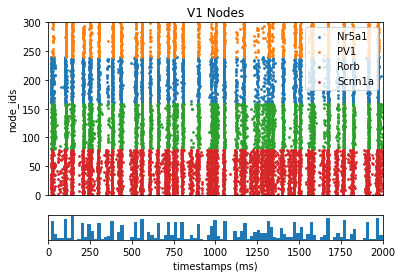

In [10]:
from bmtk.analyzer.spike_trains import plot_raster

# Plot the spike trains raster
_ = plot_raster(config_file='config.bionet.json', group_by='pop_name')

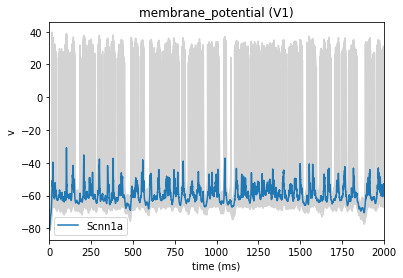

In [11]:
from bmtk.analyzer.compartment import plot_traces

# Plot the membrane potential trace
_ = plot_traces(config_file='config.bionet.json', group_by='pop_name', report_name='membrane_potential')

#### Cell perturbations

A usefull tool in network neuroscience is the ability to stimuluate or depress a one or more neurons in a network, either using optogenetic tools or current clamps. To simulate this effect in BMTK we can use a current clamp on a multiple neurons by adding the following to the "inputs" section of the configuration file:


```json
  "inputs": {
    ...
     
    "inh_perturbation": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": {
        "population": "V1",
        "pop_name": "Nr5a1", 
        "location": "L4"
      },
      "amp": -1.0,
      "delay": 500.0,
      "duration": 1500.0
    }
  }
```


In [12]:
# Will reset BioNet and the NEURON simulator. Required if we want
# to run the simulator multiple times in the same notebook.
bionet.reset()

In [13]:
conf = bionet.Config.from_json('config.bionet.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2021-06-24 11:33:07,574 [INFO] Created log file
Mechanisms already loaded from path: ./components/mechanisms.  Aborting.
2021-06-24 11:33:07,675 [INFO] Building cells.
2021-06-24 11:34:58,720 [INFO] Building recurrent connections
2021-06-24 11:37:23,018 [INFO] Building virtual cell stimulations for LGN_spikes
2021-06-24 11:37:49,440 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2021-06-24 11:37:49,441 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2021-06-24 11:37:49,442 [INFO] Block save every 5000 steps
2021-06-24 11:40:57,854 [INFO]     step:5000 t_sim:500.00 ms
2021-06-24 11:44:23,932 [INFO]     step:10000 t_sim:1000.00 ms
2021-06-24 11:47:32,163 [INFO]     step:15000 t_sim:1500.00 ms
2021-06-24 11:50:43,726 [INFO]     step:20000 t_sim:2000.00 ms
2021-06-24 11:50:43,783 [INFO] Simulation completed in 12.0 minutes, 54.34 seconds 


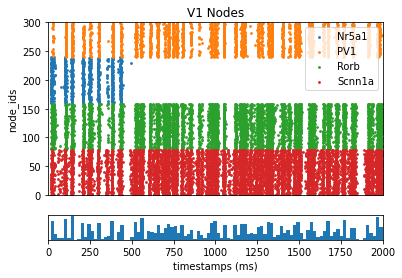

In [14]:
_ = plot_raster(config_file='config.bionet.json', group_by='pop_name')

#### Recording ECP

The configuration has been set-up to record spike-trains and the membrane potentials of a subset of cells. BioNet also includes the ability to record the extracelluar potential using a simulated electrode, which will allow us to find the ECP and even the local field potential.

First we must add the following to the "inputs" section

```json
"reports": {
  ...
   
  "ecp": {
    "module": "extracellular",
    "variable_name": "v",
    "cells": {
        "population": "V1",
        "model_type": "biophysical"
    },
    "electrode_positions": "./components/devices/linear_electrode.csv",
    "file_name": "ecp.h5",
    "electrode_channels": "all"
  }
}
```

The *devices/linear_electrode.csv* file is what we use to specify the electrode and all the recording channels. for this simulation the electrode will be placed through the center of the V1 column with recording channels at every 100 microns (the **x**, **y**, **z** coordinates of the electrode should be in the same space as the cells).

<img src="images/v1_neuropixel_probe.png" style="width: 350px; float: left"/> <!-- style="width: 5px; float: left"/> -->

| channel | x_pos | y_pos | z_pos |
| :--- | :--- | :--- | :--- |
|0 | 0.0 | 0 | 0.0 |
|1 | 0.0 | 100 | 0.0 |
|2 | 0.0 | 200 | 0.0 |
|3 | 0.0 | 300 | 0.0 |
|4 | 0.0 | 400 | 0.0 |
|5 | 0.0 | 500 | 0.0 |
|6 | 0.0 | 600 | 0.0 |
|7 | 0.0 | 700 | 0.0 |
|8 | 0.0 | 800 | 0.0 |
|9 | 0.0 | 900 | 0.0



Now we can run the simulation as before:


In [15]:
# Will reset BioNet and the NEURON simulator. Required if we want
# to run the simulator multiple times in the same notebook.
bionet.reset()

In [16]:
conf = bionet.Config.from_json('config.bionet.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2021-06-24 12:04:20,572 [INFO] Created log file
2021-06-24 12:04:20,722 [INFO] Building cells.
2021-06-24 12:04:49,375 [INFO] Building recurrent connections
2021-06-24 12:07:39,111 [INFO] Building virtual cell stimulations for LGN_spikes
2021-06-24 12:08:06,819 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2021-06-24 12:08:06,820 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2021-06-24 12:08:06,820 [INFO] Block save every 5000 steps
2021-06-24 12:26:10,664 [INFO]     step:5000 t_sim:500.00 ms
2021-06-24 12:43:55,769 [INFO]     step:10000 t_sim:1000.00 ms
2021-06-24 13:01:19,182 [INFO]     step:15000 t_sim:1500.00 ms
2021-06-24 13:19:58,561 [INFO]     step:20000 t_sim:2000.00 ms
2021-06-24 13:19:58,629 [INFO] Simulation completed in 71.0 minutes, 51.81 seconds 


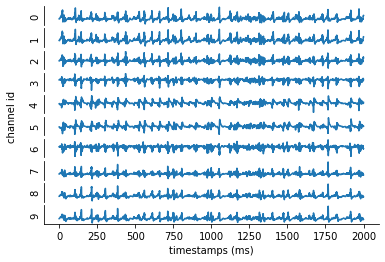

In [17]:
from bmtk.analyzer.ecp import plot_ecp

_ = plot_ecp(config_file='config.bionet.json', report_name='ecp')

#### Adjusting the synaptic  weights

Currently the synaptic weights, eg __syn_weight__ property, are set to the same for each edge-type. There are multiple ways to make it so the synaptic weights are nonhomogenous. We can calculate and store nonhomogeneous synaptic weights inside the SONATA edges files. Or we can adjust the weights before each simulation - which is a bit less efficent but will give us greater flexiblity as we try to optimize the weights.

for Exc --> Exc edges we had a BMTK special keyword __weight_function__='set_syn_weight', which allows us to create user-defined functions to adjust the synaptic weights during the initialization of the simulation. BMTK will look for a function with with signature 
```python
def <function_name>(edge_props, source, target)
```

Where **edge_props**, **source**, **target** are dictionary-like objects that can be used to fetch edges-properties, source cell properties, and target-cell properties.

For our function we want to rewrite it so the __syn_weight__ value is readjusted based on the distance.



In [18]:
# Will reset BioNet and the NEURON simulator. Required if we want
# to run the simulator multiple times in the same notebook.
bionet.reset()

In [19]:
def set_syn_weight(edge_props, source, target):
    # fetch base-line syn_weight value stored in edge_types properties
    syn_weight = edge_props["syn_weight"]
    
    # get the coords for the pre/post-synaptic cell and calculate distance
    src_coords = np.array([source['x'], source['y'], source['z']])
    trg_coords = np.array([target['x'], target['y'], target['z']])
    dist = np.linalg.norm(src_coords - trg_coords)
    
    if dist > 60: 
        return syn_weight
    else:
        return syn_weight*(-0.165*dist + 10.0)


# This will register our function so BMTK can find it
bionet.add_weight_function(set_syn_weight)
    
conf = bionet.Config.from_json('config.bionet.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()


2021-06-24 14:04:25,042 [INFO] Created log file  
2021-06-24 14:04:25,147 [INFO] Building cells.
2021-06-24 14:04:49,026 [INFO] Building recurrent connections
2021-06-24 14:07:13,852 [INFO] Building virtual cell stimulations for LGN_spikes
2021-06-24 14:07:38,980 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2021-06-24 14:07:38,980 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2021-06-24 14:07:38,980 [INFO] Block save every 5000 steps
2021-06-24 14:09:05,559 [INFO]     step:5000 t_sim:500.00 ms
2021-06-24 14:10:31,855 [INFO]     step:10000 t_sim:1000.00 ms
2021-06-24 14:11:59,001 [INFO]     step:15000 t_sim:1500.00 ms
2021-06-24 14:13:24,835 [INFO]     step:20000 t_sim:2000.00 ms
2021-06-24 14:13:24,894 [INFO] Simulation completed in 5.0 minutes, 45.91 seconds 



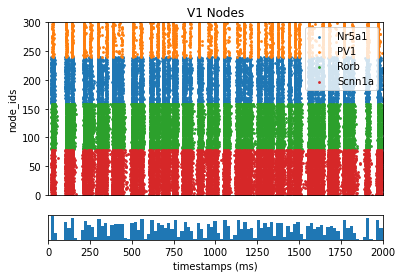

In [20]:
from bmtk.analyzer.spike_trains import plot_raster

_ = plot_raster(config_file='config.bionet.json', group_by='pop_name')

## Generating realistic stimulus

To drive our network model we have been using external "LGN" virtual cells that fire at a constant rate. This can be useful for testing some fundamental properties of the network. However to better optimize our model it will be useful to simulate it against more realistic stimulus.

FilterNet is a component of the BMTK that allows us to project an image or movie onto one or more neurons to produce spike trains. Using FilterNet with the "LGN" network we can create spike-train files using various types of visual stimulus, which can then be used as input for simulating the V1 model.

<img src="images/filternet_lnp.png" alt="Drawing" style="width: 700px; float: left"/>

### FilterNet Directory Structure

FilterNet simulation directory is structured the same as BioNet, using a json configuration file to specify the paths and parameters required to run a full simulation. The configuration and model files are already set-up, but when building a simulation from scratch one can create directory template using the command line tool:

```bash
 $ python -m bmtk.utils.sim_setup    \
   --network network                 \
   --tstop 2000.0                    \  
   --include-examples                \
   --config=config.filternet.json    \
   filternet .
```

Controlling the FilterNet simulation is done through *config.filternet.json*, which has the same format used by _config.bionet.json_, except with some noticeable changes.

##### "networks"

We only want to run FilterNet against the LGN nodes (and FilterNet currently doesn't support recurrent networks), which is reflected by the "network" sections in the configuration:

```json
  "networks": {
    "nodes": [
      {
        "nodes_file": "$NETWORK_DIR/LGN_nodes.h5",
        "node_types_file": "$NETWORK_DIR/LGN_node_types.csv"
      }
    ]
  }
```

#### "output"
Like in BioNet, FilterNet will produce a SONATA formated spike-trains file, but for our "LGN" nodes only. The location of the output is controlled by the "output" section of the configuration file:

``` json
  "output": { 
    "log_file": "log.txt",
    "output_dir": "./inputs",
    "spikes_file": "lgn_spikes.flash.h5"
  },
```

#### "inputs"

The "inputs" section of the configuration file determines which type of stimulus we want to project onto LGN cells. Although we can use any user-created movie (described below), FilterNet also comes with options for easily creating special stimulus types that are common in experiments testing the visual system.

One of the simplest types of stimuli is a full-field flash, a temporary bright (or dark) flash on the receptive field, which can be used to test simple ON/OFF cells found in the LGN. The following will create a bright flash between 500 to 1500 ms seconds

```json
  "inputs": {
    "full_field_flash": {
        "input_type": "movie",
        "module": "full_field_flash",
        "row_size": 120,
        "col_size": 240,
        "t_on": 500.0,
        "t_off": 1500.0,
        "max_intensity": -1.0,
        "frame_rate": 1000.0
    } 
  }
```

### Running the Simulation

Now that we have our configuration file setup we can run filternet. In the command line this can be done by:
    
```bash
 $ python run_filternet.py config.filernet.json
```

For every large networks that would require multiple processors to complete in a reasonable amount of time we can use the command
```bash
 $ mpirun -n <N> python run_filternet.py config.filernet.json
```

Or through the following code:


In [21]:
from bmtk.simulator import filternet

config = filternet.Config.from_json('config.filternet.json')
config.build_env()
net = filternet.FilterNetwork.from_config(config)
sim = filternet.FilterSimulator.from_config(config, net)
sim.run()

2021-06-24 14:16:06,482 [WARNING] Directory ./inputs already exists.
2021-06-24 14:16:06,483 [INFO] Created log file
2021-06-24 14:16:07,970 [INFO] Building cells.
2021-06-24 14:16:11,337 [INFO] Evaluating rates.
2021-06-24 14:16:33,327 [INFO] Done.


Once completed it will create the spikes-file lgn_results/lgn_spikes.flash.h5. This file follows the same format as the spike-trains file generated by BioNet. To see how our LGN ON/OFF cells responded to the full-field flash:

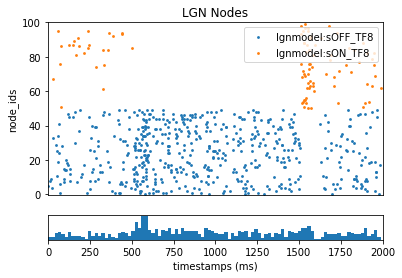

In [22]:
from bmtk.analyzer.spike_trains import plot_raster

_ = plot_raster(config_file='config.filternet.json', group_by='model_template')

#### Using the results for the V1 model

To use the results to test our V1 model with more realistic stimulus, we just need to open _config.bionet.json_ and edit the "inputs" section so the __input_file__ is changed from *./inputs/lgn_spikes.h5* to *./lgn_results/lgn_spikes.flash.h5*

```json
  "inputs": {
    ...,
      
    "LGN_spikes": {
        "input_type": "spikes",
        "module": "h5",
        "input_file": "./inputs/spikes.flash.h5",
        "node_set": "LGN"
    }
  }
```

Then just rereun the BioNet code as above and see what happens when we use the new stimulus.

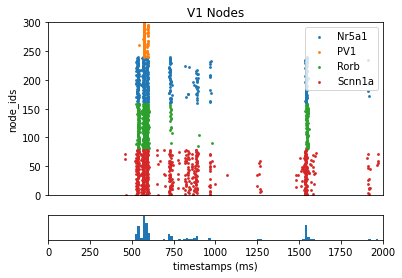

In [23]:
from bmtk.analyzer.spike_trains import plot_raster

_ = plot_raster(config_file='config.bionet.flash.json', group_by='pop_name')

### More Stimulus Types

Besides Full-Field Flashes, FilterNet also can generate other types of pre-set visual stimuli. However for more advanced stimuli one will have to create their own movies.

To do so first you will need to create a [numpy npy or npz file](https://numpy.org/doc/stable/reference/generated/numpy.save.html) - eg a 3-dimensional matrix consisting of the frames x rows x columns of each pixel. FilterNet will gray-scale the images automatically. Once the movie has been saved, open up the FilerNet json configuration file and modify the "inputs" section accordingly (make sure frame_rate is correct).

```json
  "inputs": {
    "full_field_flash": {
      "input_type": "movie",
      "module": "movie",
      "data_file": "/path/to/my/movie.npy",
      "frame_rate": 1000.0
    } 
  }
```

## Simulating across different levels of Resultion

So far we've been running a simulation using multi-compartment models of cells using the BioNet component of the BMTK. Often in modeling we want to test different types of models, for both computational and scientific reasons. 

#### Point-neuron models
With PointNet, we can run our network using point-neuron based models using the [NEST](https://www.nest-simulator.org/) simulator libraries. PointNet will also use the same SONATA network files and configuration format for describing a network and initializing a simulation, so we can compare the same network across different levels of resolution. However certain properties, like __syn_weight__, __model_template__, and __dynamics_params__ will need to be adjusted. For more information see the [PointNet tutorial](https://alleninstitute.github.io/bmtk/tutorial_pointnet_modeling.html).


#### Population based firing rate models
With PopNet we can simulate the different cell-types as singular populations using the [DipDE](http://alleninstitute.github.io/dipde/) simulator. Just like BioNet and PointNet it utilizes the SONATA formats. However instead of recording spike-trains for individual cells, PopNet will record the firing-rate dynamics over the course of the simulation. For more information see the [PopNet tutorial](https://alleninstitute.github.io/bmtk/tutorial_population_modeling.html).

## Additional Resources

https://alleninstitute.github.io/bmtk


https://github.com/AllenInstitute/bmtk/tree/develop/docs/tutorial/modeling_tut_2021


### Additional Tutorials

* **Network Builder** - https://alleninstitute.github.io/bmtk/tutorial_NetworkBuilder_Intro.html

* **BioNet** - https://alleninstitute.github.io/bmtk/tutorial_single_pop.html

* **FilterNet** - https://alleninstitute.github.io/bmtk/tutorial_filter_models.html

* **PointNet** - https://alleninstitute.github.io/bmtk/tutorial_pointnet_modeling.html

* **PopNet** - https://alleninstitute.github.io/bmtk/tutorial_population_modeling.html


### Examples

* https://github.com/AllenInstitute/bmtk/tree/develop/docs/examples



### Mouse Layer 4 Model

* http://portal.brain-map.org/explore/models/l4-mv1


### Mouse Full V1 Model

* http://portal.brain-map.org/explore/models/mv1-all-layers